# 用Monte Carlo算法计算二重积分
- 矩形区域
  - 均匀分布的随机抽样
  - 积分值的数值估计
- 一般区域
  - 外切矩形中的随机抽样
  - 所需样本总量的估计

# 矩形区域
考虑在矩形区域$D = [a, b] \times [c, d]$上均匀分布的两个独立随机变量$(X, Y)$. 其概率密度函数为
$$\rho_{XY}(x, y) = \frac{1}{(b-a)(d-c)} \equiv \frac{1}{\sigma_D},$$
其中, $\sigma_D$为该区域的面积. 所以, 若给定某二元可积函数$z = f(x, y)$, 则$f(X, Y)$的数学期望
$$\mathbb{E}[f(X, Y)] = \iint_D{f(x, y) \rho_{XY}(x, y) \mathrm{d}x \mathrm{d}y} = \frac{1}{\sigma_D} \iint_{D}{f(x, y) \mathrm{d}x \mathrm{d}y}$$
可由其按均匀分布$\mathcal{U}[a, b] \times \mathcal{U}[c, d]$抽样后计算得到的算术平均值估计:
$$\iint_{D}{f(x, y) \mathrm{d}x \mathrm{d}y} \simeq \frac{\sigma_D}{N_D} \sum_{(x, y) \in D}{f(x, y)}.$$

In [1]:
# seed everything in numpy
import numpy as np
np.random.seed(0)

## 均匀分布的随机抽样
我们用库函数[`numpy.random.rand`](https://numpy.org/doc/2.2/reference/random/generated/numpy.random.rand.html#numpy.random.rand)进行高维均匀分布的随机抽样.
- 样本起初是分布于$[0, 1)$区间内的, 我们按照矩形区域的边界对其进行线性运算;
- 用[`np.concatenate`](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html#numpy-concatenate)功能, 将各个维度的样本进行合并.

In [2]:
import numpy as np
from numpy.random import rand

def sample_rectangular_uniform(a, b, c, d, n_samples):
    return np.concatenate([(rand(n_samples) * (b - a) + a)[:, None], (rand(n_samples) * (d - c) + c)[:, None]], axis=1)

检验发现, 使用`sample_rectangular_uniform(0, 1, 0, 1, 1000)`得到的1000个样本点均匀分布于$D = [0, 1] \times [0, 1]$上.

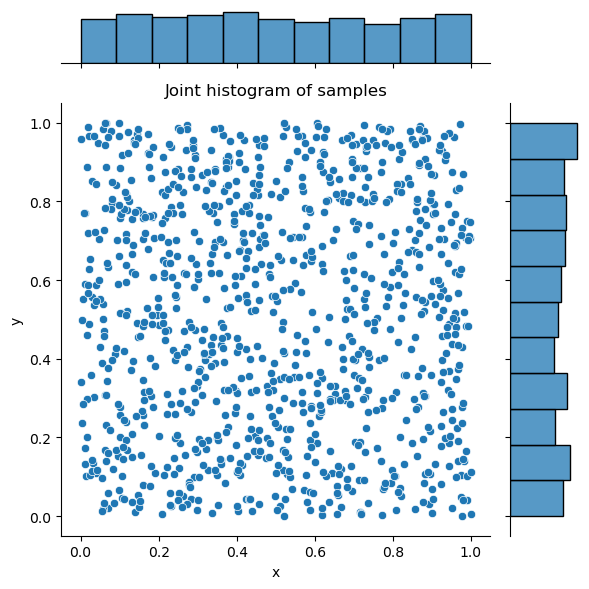

In [3]:
# plot 2d histogram of the samples
import matplotlib.pyplot as plt
import seaborn as sns
samples = sample_rectangular_uniform(0, 1, 0, 1, 1000)
sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind='scatter')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Joint histogram of samples')
plt.tight_layout()
plt.show()

## 积分值的数值估计
记$D = \left[0, \frac{\pi}{2}\right] \times [0, 1]$, 我们使用Monte Carlo算法对二重积分
$$I = \iint_D{\cos(x) \exp(y) \mathrm{d}x \mathrm{d}y} = \mathrm{e} - 1$$
进行数值估计.

In [4]:
def func(x, y):
    return np.cos(x) * np.exp(y)

def MCInt2(func, a, b, c, d, n_samples):
    samples = sample_rectangular_uniform(a, b, c, d, n_samples)
    return (b - a) * (d - c) * np.mean(func(samples[:, 0], samples[:, 1]))

由下述计算过程可见, Monte Carlo约在$10^4$个样本点下开始收敛, 且给出了准确的估计.

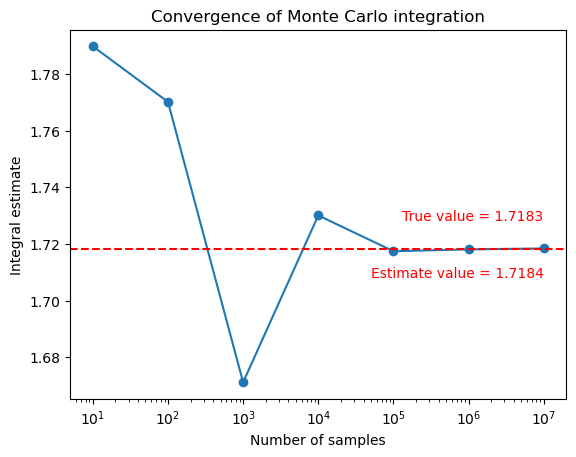

In [5]:
# inspect the convergence of the Monte Carlo integration
n_samples = [10 ** k for k in range(1, 8)]
integral_estimates = [MCInt2(func, 0, 0.5 * np.pi, 0, 1, n) for n in n_samples]
true_value = np.exp(1) - 1

plt.plot(n_samples, integral_estimates, 'o-')
plt.xscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Integral estimate')
plt.text(n_samples[-1], true_value - 0.01, f'Estimate value = {integral_estimates[-1]:.4f}', color='red', horizontalalignment='right')

# horizontal line at the true value
plt.axhline(np.exp(1) - 1, color='red', linestyle='--')
plt.text(n_samples[-1], true_value + 0.01, f'True value = {true_value:.4f}', color='red', horizontalalignment='right')

plt.title('Convergence of Monte Carlo integration')
plt.show()

# 一般区域
记$D = \{(x, y) | x^2 + y^2 \le 1\}$, 我们研究二重积分
$$I = \iint_D{\exp(-(x^2 + y^2)) \mathrm{d}x \mathrm{d}y} = 2\pi \frac{\mathrm{e} - 1}{2 \mathrm{e}} \simeq 1.9858653.$$

In [6]:
def func_nonrectangular(x, y):
    return np.exp(- (x ** 2 + y ** 2))

## 外切矩形中的随机抽样
我们尝试将积分区域$D$用一个 (尽可能小的) 外切矩形$R$“包裹”住. 例如, 对于$D = \{(x, y) | x^2 + y^2 \le 1\}$而言, 一个合理的外切矩形为$R = [-1, 1] \times [-1, 1]$.
- 完成抽样后, 我们挑选出那些符合区域$D$要求的样本点、丢掉其它点即可. `numpy`支持逻辑索引.

In [7]:
def region_criterion(x, y):
    return (x ** 2 + y ** 2 <= 1), np.pi

def MCInt2_nonrectangular(func, a, b, c, d, region_criterion, n_samples):
    samples = sample_rectangular_uniform(a, b, c, d, n_samples)
    criterion, area = region_criterion(samples[:, 0], samples[:, 1])
    samples = samples[criterion]
    return area * np.mean(func(samples[:, 0], samples[:, 1]))

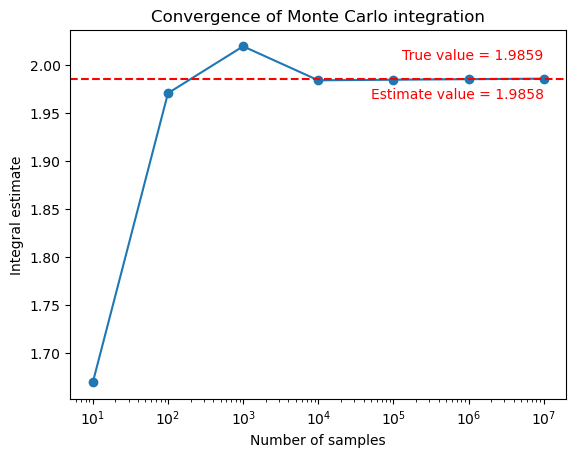

In [8]:
# inspect the convergence of the Monte Carlo integration
n_samples = [10 ** k for k in range(1, 8)]
integral_estimates = [MCInt2_nonrectangular(func_nonrectangular, -1, 1, -1, 1, region_criterion, n) for n in n_samples]
true_value = 2 * np.pi * (np.exp(1) - 1) / (2 * np.exp(1))

plt.plot(n_samples, integral_estimates, 'o-')
plt.xscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Integral estimate')
plt.text(n_samples[-1], true_value - 0.02, f'Estimate value = {integral_estimates[-1]:.4f}', color='red', horizontalalignment='right')

# horizontal line at the true value
plt.axhline(true_value, color='red', linestyle='--')
plt.text(n_samples[-1], true_value + 0.02, f'True value = {true_value:.4f}', color='red', horizontalalignment='right')

plt.title('Convergence of Monte Carlo integration')
plt.show()

## 所需样本总量的估计
由于存在样本丢弃的现象, 非矩形区域中的总样本数量$N_R$需要预设得比区域$D$内所需的样本量$N_D$大一些. 根据概率论知识, 容易得到
$$\frac{\sigma(D)}{\sigma(R)} \simeq \frac{N_D}{N_R}.$$
则我们可以根据$N_D$反推出
$$N_R \simeq N_D \frac{\sigma(R)}{\sigma(D)}.$$